This notebook is developed using ml.m5.8xlarge instance with `Python 3 (Data Science)` kernel on SageMaker Studio.

In [ ]:
!pip install -q nibabel nilearn
!apt update
!apt install zip

In [ ]:
import os
import glob
import time
import boto3
import sagemaker
import numpy as np
import nibabel as nib
from nilearn import plotting
from itertools import islice
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
boto_session = boto3.Session(region_name=region)
account_id = boto3.client('sts').get_caller_identity().get('Account')
bucket = sagemaker_session.default_bucket()

dataset_prefix = 'medical-imaging/dataset'
scaled_dataset_prefix = 'medical-imaging/scaled_dataset'
scaled_zipped_dataset_prefix = 'medical-imaging/scaled_zipped_dataset'

%matplotlib inline
t0 = time.time()

### Download dataset

In [ ]:
!mkdir ./dataset/
!aws s3 cp --no-sign-request s3://msd-for-monai/Task01_BrainTumour.tar ./dataset/Task01_BrainTumour.tar

### Unpack the dataset tar archive

In [ ]:
!tar xvf ./dataset/Task01_BrainTumour.tar -C ./dataset/

### Write data to your S3

In [ ]:
!aws s3 sync ./dataset/Task01_BrainTumour/ s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

In [ ]:
!aws s3 ls s3://{bucket}/{dataset_prefix}/Task01_BrainTumour/

Install neuroimaging libraries and import

In [7]:
from nilearn import image

### EDA

In [ ]:
nii = nib.load('dataset/Task01_BrainTumour/imagesTr/BRATS_001.nii.gz')
seg = nib.load('dataset/Task01_BrainTumour/labelsTr/BRATS_001.nii.gz')
print(nii)

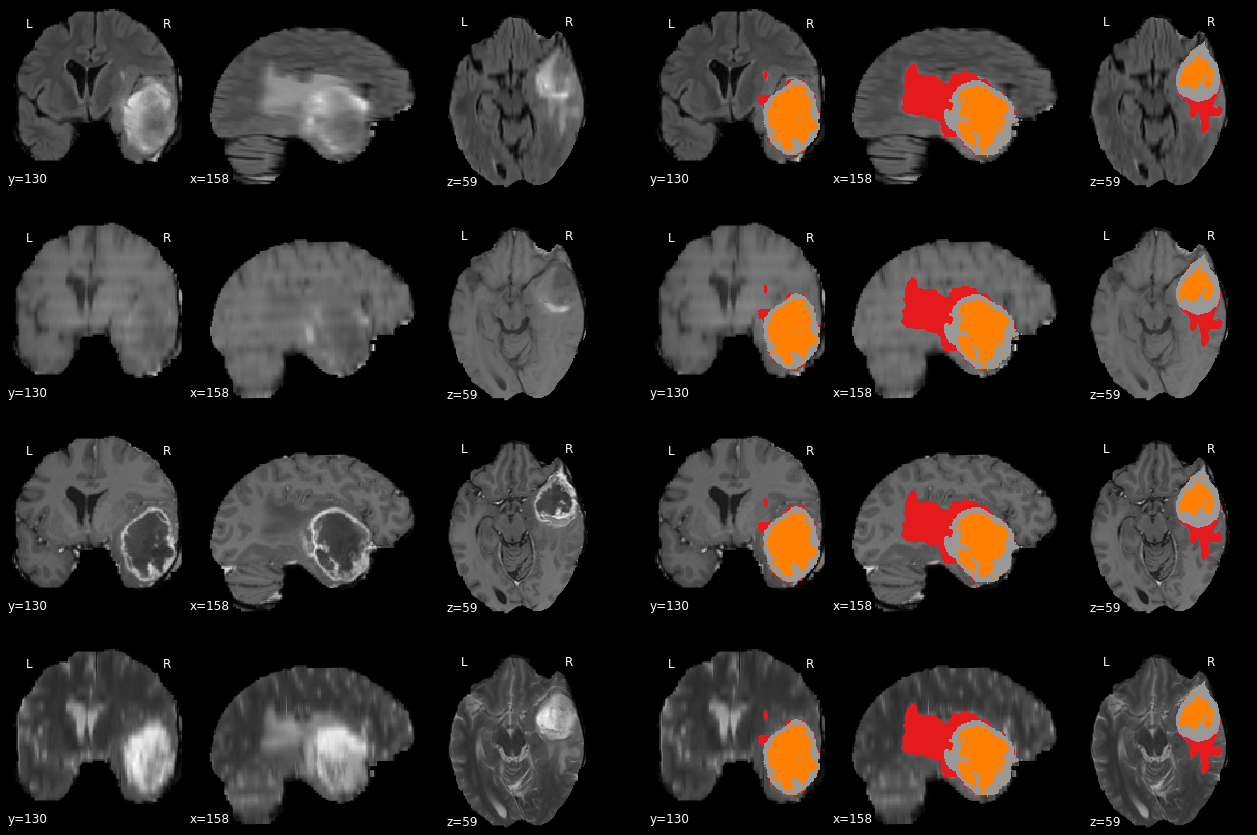

In [9]:
niis_by_channel = [image.index_img(nii, i) for i in range(nii.shape[-1])]

f, ax = plt.subplots(4,2, figsize=(18,12), facecolor=(0, 0, 0))
f.tight_layout()

for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][0], 
                      alpha = 0, dim=0, draw_cross = False
                     )
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i][1], 
                      alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                     )
#f.savefig('./datasets/BRATS_001_fig.png', dpi=150, facecolor=(0, 0, 0))

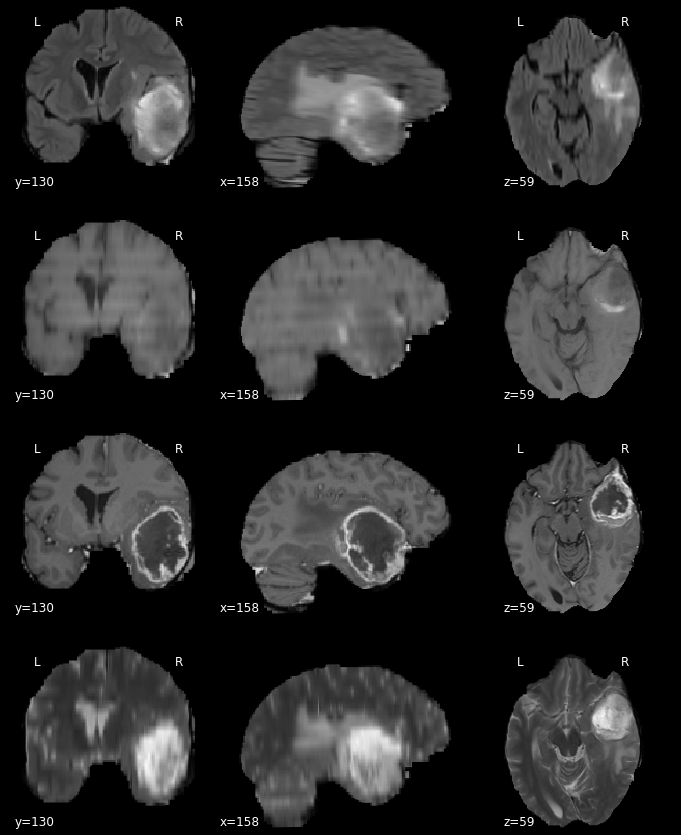

In [10]:
f, ax = plt.subplots(4,1, figsize=(10,12), facecolor=(0, 0, 0))
f.tight_layout()
for i in range(len(niis_by_channel)):
    plotting.plot_roi(seg, bg_img=niis_by_channel[i], figure=f, axes=ax[i], 
                      alpha = 0, dim=0, draw_cross = False
                     )
#f.savefig('./datasets/BRATS_001_fig_3.png', dpi=150, facecolor=(0, 0, 0))

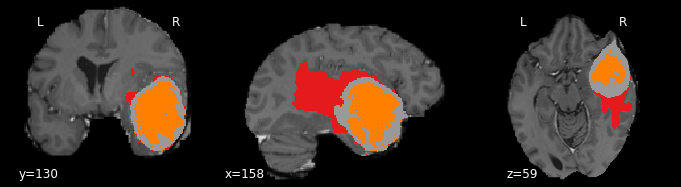

In [11]:
f, ax = plt.subplots(1,1, figsize=(10, 3), facecolor=(0, 0, 0))
f.tight_layout()
plotting.plot_roi(seg, bg_img=niis_by_channel[2], figure=f, axes=ax,
                  alpha = 1, cmap = 'Set1', dim=0, draw_cross = False
                 )
#f.savefig('./datasets/BRATS_001_fig_3_label.png', dpi=150, facecolor=(0, 0, 0))

Combine each input/output pair into a single S3 key in order to take advantage of ShardedByS3Key feature of SageMaker Processing

In [ ]:
data_dir = './dataset/Task01_BrainTumour/'

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [{"image": image_name, "label": label_name}
              for image_name, label_name in zip(train_images, train_labels)
             ]

print(len(data_dicts))
print(data_dicts[0])

### Loop 100 times over each pair, combine in a zip and write to S3.

In [13]:
# Create directory for zipped input/output pairs
zipped_dataset_path = "./zipped_dataset"
!mkdir {zipped_dataset_path}

In [14]:
def create_synthetic_data(io_paths):
    for pair in io_paths:
        # Create 100 copies of each input/output pairs
        for i in range(1, 101):
            
            # Create a dir for ith copy of input/output pairs
            sample_name = pair['image'].split("/")[-1].split('.')[0]
            ith_copy_dir = sample_name+"_Copy{}".format(i)
            !mkdir {zipped_dataset_path}/{ith_copy_dir}
            
            # Copy ith sample 100 times to above directory (ith_copy_dir)
            current_path = zipped_dataset_path + "/" + ith_copy_dir
            ith_image_name = "{}/{}_Copy{}_image.nii.gz".format(current_path, sample_name, i)
            ith_label_name = "{}/{}_Copy{}_label.nii.gz".format(current_path, sample_name, i)
            !cp {pair["image"]} {ith_image_name}
            !cp {pair["label"]} {ith_label_name}
            
            # Send copy to S3
            !aws s3 cp {ith_image_name} s3://{bucket}/{scaled_dataset_prefix}/{"imagesTr"}/
            !aws s3 cp {ith_label_name} s3://{bucket}/{scaled_dataset_prefix}/{"labelsTr"}/

            # Zip current copy of input/output pairs into one file
            !zip -rm {current_path}.zip {current_path}
            
            # Send zipped copy to S3
            !aws s3 cp {current_path}.zip s3://{bucket}/{scaled_zipped_dataset_prefix}/{ith_copy_dir}.zip


### Use multiprocessing to run above function in a CPU pool
#### Note: On a 32 CPU EC2 instance, this step should take about two hours.

In [15]:
slice_per_cpu = len(data_dicts)//(cpu_count() - 2)
reminder = len(data_dicts)%(cpu_count() - 2)

length_to_split = [slice_per_cpu]*(cpu_count() - 2)

data_dicts_iter = iter(data_dicts)

splits = [list(islice(data_dicts_iter, elem))
          for elem in length_to_split]

splits.append(data_dicts[-1*reminder:])

In [ ]:
t1 = time.time()
# Creates one process per machine cpu
pool = Pool(processes = cpu_count() - 1)
result = pool.map(create_synthetic_data, splits)
t2 = time.time()

In [ ]:
print( (t2-t1)/60 )

In [ ]:
print( (t2-t0)/60 )